In [1]:
import tifffile
import euler_gpu
import os, random
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py
from tqdm import tqdm
device = torch.device("cuda:0")
BATCH_SIZE = 100

In [2]:
tiff_path = "/store1/alicia/jellyfish/concat_cropped_12000-29999.tif"
inputs = tifffile.imread(tiff_path)

In [8]:
inputs.shape

red_offset = 12000

In [12]:
green_channel_folder = "/home/brian/store1/brian/swiming_videos/GREEN CROPPED VIDEO FOR BRIAN"
green_files = sorted([f for f in os.listdir(green_channel_folder) if int(f.split('-')[0]) >= red_offset], key=lambda x: int(x.split('-')[0])) # f.index("WARPED") < 0 and 
green_offsets = [int(f.split('-')[0]) - red_offset for f in green_files]
print(green_files)

['12000-13999.tif - C=0.tif', '14000-15999.tif - C=0.tif', '16000-17999.tif - C=0.tif', '18000-19999.tif - C=0.tif', '20000-21999.tif - C=0.tif', '22000-23999.tif - C=0.tif', '24000-25999.tif - C=0.tif', '26000-27999.tif - C=0.tif', '28000-29999.tif - C=0.tif']


In [4]:
ALIGN_XY_RANGE = np.linspace(-0.01, 0.01, 50, dtype=np.float32)
# ALIGN_TH_RANGE = np.concatenate((np.linspace(0, 10, 20, dtype=np.float32), np.linspace(350, 360, 20, dtype=np.float32)))
ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .17, 20, dtype=np.float32), np.linspace(3, 3.141592, 20, dtype=np.float32)))

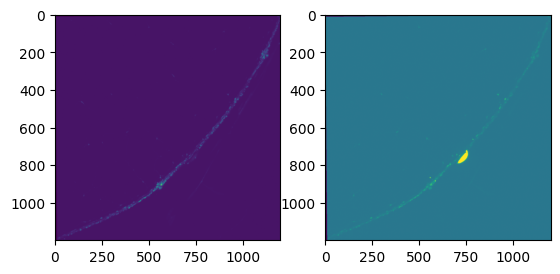

In [4]:
red_channel = 0
green_channel = 1
fixed_frame = 931

red_image = inputs[fixed_frame, red_channel]
green_image = inputs[fixed_frame, green_channel]

# red_image = np.log((red_image - np.min(red_image)) + 1)
# green_image_log = np.log((green_image - np.min(green_image)) + 1)
# green_image = np.sqrt((green_image - np.min(green_image)))
green_image_log = np.minimum(green_image, 250)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(red_image)
ax[1].imshow(green_image_log)

## Align Entire Video

In [2]:
tiff_folder = "/storage/fs/store1/brian/swiming_videos/Folder_20240930105926_good"
date = "20240930"
tiff_files = sorted([f for f in os.listdir(tiff_folder) if os.path.splitext(f)[-1] == ".tif" and f.find(date) >= 0 and
                     (f.find("RIG") < 0 and f.find("WARP") < 0 and f.find("CHAN") < 0)], key=lambda x: int(x.split('_')[-1].split('-')[0])) 
print(tiff_files)


['20240930_0-1999.tif', '20240930_2000-3999.tif', '20240930_4000-5999.tif', '20240930_6000-7999.tif', '20240930_8000-9999.tif', '20240930_10000-11999.tif', '20240930_12000-13999.tif', '20240930_14000-15999.tif', '20240930_16000-17999.tif', '20240930_18000-19999.tif']


In [3]:
# ALIGN_XY_RANGE = np.linspace(-0.008, 0.008, 40, dtype=np.float32)
# ALIGN_XY_RANGE = np.linspace(-0.0008, 0.0008, 20, dtype=np.float32)
ALIGN_XY_RANGE = np.linspace(-0.001, 0.001, 20, dtype=np.float32)
ALIGN_TH_RANGE = np.concatenate((np.linspace(0, .004, 10, dtype=np.float32), np.linspace(3.12, 3.141592, 10, dtype=np.float32)))

In [6]:
num_frames = 20

red_channel = 0
green_channel = 1

x_tot = 0.0
y_tot = 0.0
th_tot = 0.0


ins = tifffile.imread(os.path.join(tiff_folder, tiff_files[5]))
frames = random.sample(range(ins.shape[0]), num_frames)
for frame in tqdm(frames):
    red_image = ins[frame, red_channel]
    green_image = ins[frame, green_channel]
    green_image_log = np.minimum(green_image, 250)

    memory_dict = euler_gpu.initialize(red_image, green_image_log, ALIGN_XY_RANGE, ALIGN_XY_RANGE, ALIGN_TH_RANGE, BATCH_SIZE, device)
    best_score, best_transformation = euler_gpu.grid_search(memory_dict)

    x_tot += best_transformation[0]
    y_tot += best_transformation[1]
    th_tot += best_transformation[2]

print(x_tot/num_frames)
print(y_tot/num_frames)
print(th_tot/num_frames)


100%|██████████| 20/20 [02:38<00:00,  7.94s/it]

tensor([0.0001], device='cuda:0')
tensor([-0.0006], device='cuda:0')
tensor([6.9813e-05], device='cuda:0')


In [7]:
for file in tqdm(tiff_files):
    ins = tifffile.imread(os.path.join(tiff_folder, file))
    for frame in range(ins.shape[0]):
        in_img = ins[frame, green_channel]
        in_img = torch.Tensor(in_img[np.newaxis, np.newaxis, ...]).to(device=device)
        ins[frame, green_channel] = euler_gpu.transform_image(in_img, best_transformation[0], best_transformation[1], best_transformation[2], memory_dict).cpu().numpy()
    tifffile.imwrite(os.path.join(tiff_folder, "CHAN_" + file), ins, imagej=True)

  0%|          | 0/10 [00:00<?, ?it/s]/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'CHAN_20240930_0-1999.tif'> truncating ImageJ file
  warnings.warn(
 10%|█         | 1/10 [00:30<04:33, 30.44s/it]/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'CHAN_20240930_2000-3999.tif'> truncating ImageJ file
  warnings.warn(
 20%|██        | 2/10 [01:01<04:06, 30.85s/it]/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'CHAN_20240930_4000-5999.tif'> truncating ImageJ file
  warnings.warn(
 30%|███       | 3/10 [03:37<10:15, 87.92s/it]/home/brian/.conda/envs/PB/lib/python3.11/site-packages/tifffile/tifffile.py:3784: UserWarning: <tifffile.TiffWriter 'CHAN_20240930_6000-7999.tif'> truncating ImageJ file
  warnings.warn(
 40%|████      | 4/10 [06:16<11:37, 116.17s/it]/home/brian/.conda/envs/PB/l